In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from data.data_loader import generateGauss
from utils.integral import grid
from Models.classification import SVM
from utils.kernel import Kernel

In [3]:
h = 0.01
x_grid = grid(h, start=-2, end=12)

mu_A = [1, 1.5, 2, 2.5, 6]
sig_A = 0.4 * np.ones_like(mu_A)
mu_B = [4.5, 7.5, 8.5, 8, 8.5]
sig_B = 0.9 * np.ones_like(mu_A)

class1_data = generateGauss(mu_A, sig_A, x_grid)
class2_data = generateGauss(mu_B, sig_B, x_grid)
all_pdfs = np.vstack([class1_data, class2_data])

print(all_pdfs.shape)

y = np.array([0]*len(class1_data) + [1]*len(class2_data))
n_A, n_B = len(class1_data), len(class2_data)

(10, 1401)


In [4]:
print("\n=== SVM ===")

# Tạo kernel cho training
kc = Kernel(h=0.01, Dim=1)
K_train = kc.L1(all_pdfs, gamma=2)  # (n_train, n_train)

# Giả sử bạn có K_train (n_samples x n_samples) và y = {0,1}
svm_model = SVM.Model(C=6)
svm_model.fit(K_train, y)

# Dự đoán
probas = svm_model.predict_proba(K_train)  # xác suất
preds = svm_model.predict(K_train)         # nhãn 0 hoặc 1
f_vals = svm_model.decision_function(K_train)  # giá trị f(x)



=== SVM ===


In [5]:
new_pdf = generateGauss([3], [0.9], x_grid).ravel()

# Tạo kernel giữa (train, new_sample) → (n_train, 1)
K_full = kc.L1(np.vstack([all_pdfs, new_pdf[None, :]]))  # (n_train+1, n_train+1)
K_new = K_full[:-1, -1][:, None]  # (n_train, 1)

# Predict class và probability cho new_pdf
pred_svm = svm_model.predict(K_new)[0]
prob_svm = svm_model.predict_proba(K_new)[0, 1]
print(f"[SVM] New sample → Class: {pred_svm}, Probability (class 1): {prob_svm:.4f}")

[SVM] New sample → Class: 0, Probability (class 1): 0.0792


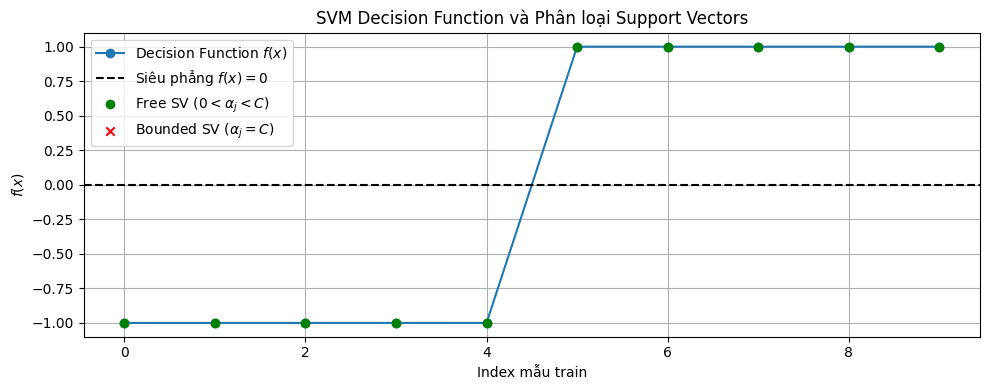

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ====== Giả lập đầu vào để vẽ (bạn cần thay bằng từ mô hình thực tế) ======
# Giả sử bạn đã train xong và có các thông tin sau từ svm_model
decision_values = svm_model.decision_function(K_train)
alpha = svm_model.alpha
C = svm_model.C

# Tìm chỉ số của SV
free_sv = np.where((alpha > 1e-5) & (alpha < C - 1e-5))[0]
bounded_sv = np.where(alpha >= C - 1e-5)[0]

# ======= Vẽ đồ thị =======
plt.figure(figsize=(10, 4))
plt.plot(decision_values, 'o-', label='Decision Function $f(x)$')
plt.axhline(0, color='black', linestyle='--', label='Siêu phẳng $f(x)=0$')

# Vẽ support vectors
plt.scatter(free_sv, decision_values[free_sv], 
            color='green', label='Free SV ($0 < \\alpha_j < C$)', zorder=10)
plt.scatter(bounded_sv, decision_values[bounded_sv], 
            color='red', marker='x', label='Bounded SV ($\\alpha_j = C$)', zorder=10)

plt.title("SVM Decision Function và Phân loại Support Vectors")
plt.xlabel("Index mẫu train")
plt.ylabel("$f(x)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
